In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
import json
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
vocab_size = 10000 # El número de palabras que tendrá mi dicc
embedding_dim = 16 # La dimensión de mi embebido
max_length = 32 # El núnero máx de palabras por oración
trunc_type = 'post' #Cómo lo trunqueo
padding_type = 'post' #Cómo lo padeo
oov_tok = "<OOV>" #Cómo reemplazaré los valores que no aparecieron en train
training_size=20000 #Con cuánto de mi data voy a entrenar

In [5]:
!wget --no-check-certificate \
  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
  -O /tmp/sarcasm.json

--2020-02-16 18:09:22--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.211.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.211.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2020-02-16 18:09:22 (167 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [0]:
#Abrimos el archivo de sarcamos en json y lo leemos declarandolo como datastore
with open("/tmp/sarcasm.json","r") as f:
  datastore = json.load(f)

#Ahora, dividiremos ese archivo en json en diferentes listas... estas listas será las sgtes.
sentences = []
labels = []
urls = []
# Como la data está en json, voy a sacarla a listas para poder procesarla con mi Tokenizer
for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])
  urls.append(item['article_link'])

# Ahora ya tengo mi data en listas, vamos a dividirla en oraciones de entrenamiento y de testeo

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = np.array(labels[0:training_size])
testing_labels = np.array(labels[training_size:])

#Hasta acá ya tendría el equivalente a mi X_train, X_test, y_train, y_test
#Ahora, los voy a secuenciar y paddear.
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok) #Los tokenizaré (transf a números)
tokenizer.fit_on_texts(training_sentences) 

#Lo convierto a diccionario una vez tokenizado... con .word_index
word_index = tokenizer.word_index

#Ahora, voy a crear las secuencias...
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_sequences[1:5]
#Como vemos, son las oraciones tokenizadas de acuerdo al word_index y en unas listas

#Ahora vamos a paddear estas tokenizaciones
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = 'post', truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,  maxlen = max_length, padding = 'post', truncating=trunc_type)

### En este notebook vamos a implementar por primera vez LSTM networks...



In [0]:
# Haremos un modelo, donde el segundo layer es un LSTM. Previamente tengo que cargar mi data y hacer el padding y tokenizer.

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), #Este parámetro me dice el # de outputs que quiero
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
# Nota que el output del bidireccional es 128. Lo dobla del input.

#Ahora, podemos alimentar un LSTM junto con otro:

model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), #El return_sequences me asegura que el output de esta N coincida con el de la sgte.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Ahora vamos a entrenar estas redes


In [15]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
num_epochs=30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=2)

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 - 16s - loss: 0.3838 - accuracy: 0.8188 - val_loss: 0.3346 - val_accuracy: 0.8568
Epoch 2/30
20000/20000 - 8s - loss: 0.1945 - accuracy: 0.9227 - val_loss: 0.3741 - val_accuracy: 0.8493
Epoch 3/30
20000/20000 - 8s - loss: 0.1065 - accuracy: 0.9610 - val_loss: 0.4765 - val_accuracy: 0.8453
Epoch 4/30
20000/20000 - 8s - loss: 0.0583 - accuracy: 0.9805 - val_loss: 0.5616 - val_accuracy: 0.8383
Epoch 5/30
20000/20000 - 8s - loss: 0.0375 - accuracy: 0.9868 - val_loss: 0.6509 - val_accuracy: 0.8454
Epoch 6/30
20000/20000 - 8s - loss: 0.0189 - accuracy: 0.9941 - val_loss: 0.8628 - val_accuracy: 0.8353
Epoch 7/30
20000/20000 - 8s - loss: 0.0177 - accuracy: 0.9940 - val_loss: 0.8207 - val_accuracy: 0.8337
Epoch 8/30
20000/20000 - 8s - loss: 0.0154 - accuracy: 0.9951 - val_loss: 0.9003 - val_accuracy: 0.8353
Epoch 9/30
20000/20000 - 8s - loss: 0.0082 - accuracy: 0.9977 - val_loss: 1.0222 - val_accuracy: 0.8363
Epoch 10/30
20

In [0]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

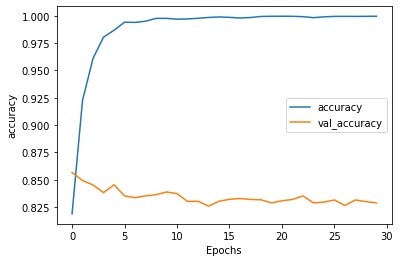

In [23]:
plot_graphs(history, 'accuracy')

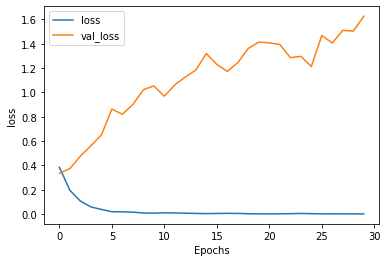

In [24]:
plot_graphs(history, 'loss')

Ahora, qué pasaría si uso una red convolucional y aparte una red GRU? 


In [0]:
# Model Definition with Conv1D
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model3.summary()

In [0]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model4.summary()